Tai file wav tu ytb ve test

In [10]:
import time,random
import os
import json
import yt_dlp
from pydub import AudioSegment

def download_and_convert_youtube(link, save_path_wav):
    temp_file = save_path_wav.replace('.wav', '')

    ydl_opts = {
    'format': 'bestaudio/best',
    'outtmpl': temp_file,
    'quiet': True,
    'cookiefile': 'cookie.txt' # file content cookie youtube
    }
    ydl_opts_info = {
        'quiet': True,
        'skip_download': True,
        'cookiefile': 'cookie.txt'
    }
    try:
        with yt_dlp.YoutubeDL(ydl_opts_info) as ydl:
            info = ydl.extract_info(link, download=False)
            # duration = info.get("duration", 0)

            # if duration > 600:
            #     print(f"video dài hơn 10 phút: {link} ({duration // 60} phút)")
            #     return
        # dowload wav
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            print(f"🎵 Đang tải: {link}")
            ydl.download([link])
            time.sleep(random.uniform(5, 15))
        if not os.path.exists(temp_file):
            raise FileNotFoundError(f"Không tìm thấy file tạm: {temp_file}")

        audio = AudioSegment.from_file(temp_file)
        audio = audio.set_channels(1).set_frame_rate(16000)
        audio.export(save_path_wav, format="wav")
        os.remove(temp_file)
        print(f" Đã lưu: {save_path_wav}")
    except Exception as e:
        print(f" Lỗi với {link}: {e}")

In [ ]:
download_and_convert_youtube()

In [7]:
import tensorflow as tf
print(tf.__version__)

2.19.0


test tung batch , moi batch 30s 

In [1]:
import librosa as lb
import numpy as np
import torch
from torchvision import transforms
from PIL import Image

def preprocess_audio(file_path, duration=30, sr=22050, image_size=224):
    """
    Xử lý 1 file wav đầu vào: cắt 30s, tạo mel spectrogram, resize về (224x224)
    Trả về tensor ảnh (3, 224, 224)
    """
    # Load và lấy 30s từ đầu (hoặc random nếu muốn)
    y, _sr = lb.load(file_path, sr=sr)
    target_length = duration * sr

    if len(y) > target_length:
        y = y[:target_length]
    else:
        y = np.pad(y, (0, max(0, target_length - len(y))))

    # Mel Spectrogram
    S = lb.feature.melspectrogram(y=y, sr=sr)
    S_db = lb.amplitude_to_db(S, ref=np.max)

    # Chuẩn hóa về [0, 255] và chuyển sang ảnh grayscale
    img = (S_db - S_db.min()) / (S_db.max() - S_db.min()) * 255
    img = np.uint8(img)
    img = Image.fromarray(img)

    # Resize và chuyển sang tensor
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),  # Tự động scale về [0,1]
    ])
    
    img_tensor = transform(img)
    return img_tensor.unsqueeze(0) 


In [ ]:
import librosa as lb
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import cv2

def show_mel_spec(file_path, duration=30, sr=22050):
    """
    Load file âm thanh, tạo ảnh mel-spectrogram resize về 224x224 và hiển thị
    """
    y, _ = lb.load(file_path, sr=sr)
    target_length = duration * sr
    if len(y) < target_length:
        y = np.pad(y, (0, target_length - len(y)))
    else:
        y = y[:target_length]

    # Tạo Mel-spectrogram
    S = lb.feature.melspectrogram(y=y, sr=sr)
    S_db = lb.amplitude_to_db(S, ref=np.max)

    # Resize về 224x224 bằng OpenCV
    S_db_resized = cv2.resize(S_db, (224, 224))

    # Hiển thị ảnh với colormap đẹp (magma, inferno, viridis...)
    plt.figure(figsize=(4, 4))
    plt.imshow(S_db_resized, aspect='auto', cmap='viridis')
    plt.show()


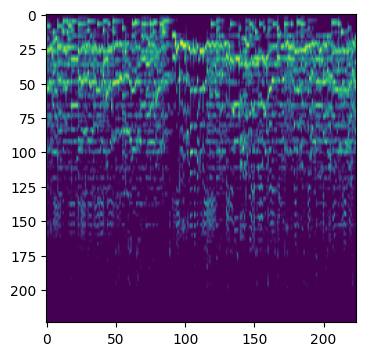

In [25]:
show_mel_spec(r"D:\classified_music\data\cheo\cheo_1_part7.wav")

In [43]:
import numpy as np
import librosa as lb
import matplotlib.pyplot as plt
from PIL import Image
import io

def wav_to_melspec_image(file_path, duration=30, sr=22050):
    y, _ = lb.load(file_path, sr=sr)
    target_length = duration * sr
    if len(y) < target_length:
        y = np.pad(y, (0, target_length - len(y)))
    else:
        y = y[:target_length]

    S = lb.feature.melspectrogram(y=y, sr=sr)
    S_db = lb.amplitude_to_db(S, ref=np.max)

    # Vẽ ảnh spectrogram với matplotlib (giữ nguyên màu)
    fig = plt.figure(figsize=(2.24, 2.24), dpi=100)  # 224x224 pixels
    plt.axis('off')
    plt.imshow(S_db, aspect='auto', cmap='viridis')
    
    # Lưu vào bộ nhớ RAM
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    buf.seek(0)

    # Mở bằng PIL
    image = Image.open(buf).convert('RGB')
    image = image.resize((224, 224))  # Resize lại nếu cần
    return image


In [47]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import time


In [49]:
from torchvision import transforms
import numpy as np
import librosa as lb
import matplotlib.pyplot as plt
from PIL import Image
import io

# Định nghĩa transform như ImageFolder dùng
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

def wav_to_melspec_tensor(file_path, duration=30, sr=22050):
    y, _ = lb.load(file_path, sr=sr)
    target_length = duration * sr
    if len(y) < target_length:
        y = np.pad(y, (0, target_length - len(y)))
    else:
        y = y[:target_length]

    S = lb.feature.melspectrogram(y=y, sr=sr)
    S_db = lb.amplitude_to_db(S, ref=np.max)

    # Vẽ ảnh spectrogram
    fig = plt.figure(figsize=(2.24, 2.24), dpi=100)  # Kích thước 224x224
    plt.axis('off')
    plt.imshow(S_db, aspect='auto', cmap='viridis')
    
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    buf.seek(0)

    image = Image.open(buf).convert('RGB')
    image = image.resize((224, 224))  # Nếu muốn resize lại

    # Áp dụng transform
    tensor = transform(image)
    return tensor


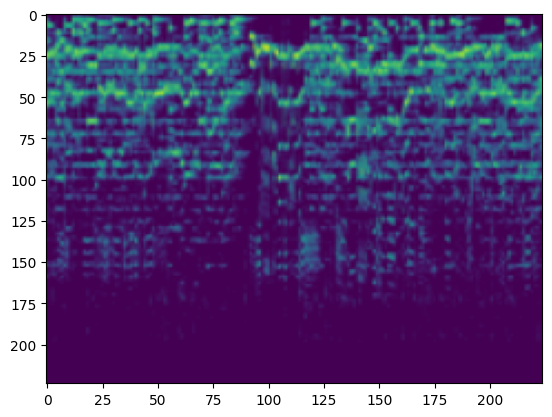

In [45]:
plt.imshow(img, aspect='auto', cmap='viridis')
plt.show(img)

In [2]:
def predict(file_path, model, class_names, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.eval()
    x = preprocess_audio(file_path).to(device)

    with torch.no_grad():
        outputs = model(x)
        probs = torch.softmax(outputs, dim=1)
        confidence, pred = torch.max(probs, 1)

    predicted_class = class_names[pred.item()]
    print(f"🎵 Predict: {predicted_class} (Confidence: {confidence.item():.2f})")
    return predicted_class, confidence.item()


In [ ]:
def predict_multiple_segments(file_path, model, class_names, segment_duration=30, sr=22050):
    y, _ = lb.load(file_path, sr=sr)
    total_samples = len(y)
    segment_samples = segment_duration * sr
    results = []

    for start in range(0, total_samples, segment_samples):
        y_segment = y[start:start + segment_samples]
        if len(y_segment) < segment_samples:
            break  # bỏ đoạn cuối nếu ngắn hơn

        # Tạo spectrogram
        padded_y = np.pad(y_segment, (0, max(0, segment_samples - len(y_segment))))
        S = lb.feature.melspectrogram(y=padded_y, sr=sr)
        S_db = lb.amplitude_to_db(S, ref=np.max)
        img = (S_db - S_db.min()) / (S_db.max() - S_db.min()) * 255
        img = Image.fromarray(np.uint8(img)).convert("RGB")
        

    return results


In [50]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import time
from torchvision.models import efficientnet_b0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 3 
class_names = ['cheo', 'remix', 'thieunhi']
print("Using device:", device)
model = efficientnet_b0(pretrained=False)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model.load_state_dict(torch.load(r"D:\classified_music\vn_5_class.pth", map_location=device))
model.to(device)
model.eval()

Using device: cuda


d:\classified_music\env_test\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\classified_music\env_test\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [61]:
tensor_input = wav_to_melspec_tensor(r"D:\classified_music\add_dataset\cheo\cheo_add1_part28.wav")  # [3, 224, 224]
tensor_input = tensor_input.unsqueeze(0)  # Thêm batch dimension -> [1, 3, 224, 224]
tensor_input = tensor_input.to(device)
model.eval()
with torch.no_grad():
    output = model(tensor_input)
    predicted_class = torch.argmax(output, dim=1).item()
    print("Dự đoán:", class_names[predicted_class])


Dự đoán: cheo


In [62]:
def wav_to_melspec_tensor_segments(file_path, segment_duration=30, sr=22050):
    y, _ = lb.load(file_path, sr=sr)
    segment_length = segment_duration * sr
    num_segments = len(y) // segment_length

    tensors = []

    for i in range(num_segments):
        segment = y[i * segment_length : (i + 1) * segment_length]
        S = lb.feature.melspectrogram(y=segment, sr=sr)
        S_db = lb.amplitude_to_db(S, ref=np.max)

        fig = plt.figure(figsize=(2.24, 2.24), dpi=100)
        plt.axis('off')
        plt.imshow(S_db, aspect='auto', cmap='viridis')

        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        plt.close(fig)
        buf.seek(0)

        image = Image.open(buf).convert('RGB')
        image = image.resize((224, 224))
        tensor = transform(image)
        tensors.append(tensor)

    return tensors  # list of [3, 224, 224]


In [87]:
# Load các đoạn từ file dài
tensors = wav_to_melspec_tensor_segments(r"G:\Trung Tam SX/2025-04/16/01-NSNDMinhThu-6Album/8935349494352/8935349494352_1_9.wav")

# Nếu không có đoạn nào thì báo lỗi
if not tensors:
    print("File quá ngắn, không đủ 30s để xử lý.")
else:
    tensor_batch = torch.stack(tensors)  # [num_segments, 3, 224, 224]
    tensor_batch = tensor_batch.to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(tensor_batch)  # [num_segments, num_classes]
        predicted_classes = torch.argmax(outputs, dim=1)  # [num_segments]
    
    # Đếm số lượng mỗi lớp
    from collections import Counter
    counts = Counter(predicted_classes.cpu().numpy())
    
    # In kết quả
    print("Dự đoán từng đoạn:")
    for i, cls in enumerate(predicted_classes):
        print(f"  Đoạn {i+1}: {class_names[cls.item()]}")
    
    # Dự đoán chung theo đa số
    final_class = counts.most_common(1)[0][0]
    print(f"\n Dự đoán cuối cùng (đa số): {class_names[final_class]}")


Dự đoán từng đoạn:
  Đoạn 1: thieunhi
  Đoạn 2: cheo
  Đoạn 3: cheo
  Đoạn 4: cheo
  Đoạn 5: cheo
  Đoạn 6: thieunhi
  Đoạn 7: thieunhi
  Đoạn 8: cheo
  Đoạn 9: thieunhi
  Đoạn 10: cheo

 Dự đoán cuối cùng (đa số): cheo


In [89]:
from collections import Counter

# Load các đoạn từ file dài
tensors = wav_to_melspec_tensor_segments(r"G:\Trung Tam SX/2025-04/16/01-NSNDMinhThu-6Album/8935349494437/8935349494437_1_9.wav")

if not tensors:
    print("File quá ngắn, không đủ 30s để xử lý.")
else:
    tensor_batch = torch.stack(tensors)  # [num_segments, 3, 224, 224]
    tensor_batch = tensor_batch.to(device)

    model.eval()
    import torch.nn.functional as F

    model.eval()
    with torch.no_grad():
        outputs = model(tensor_batch)  # [num_segments, num_classes]
        probabilities = F.softmax(outputs, dim=1)  # [num_segments, num_classes]
        predicted_classes = torch.argmax(probabilities, dim=1)


    # Đếm số lượng dự đoán
    counts = Counter(predicted_classes.cpu().numpy())
    total = sum(counts.values())

    print("🎯 Xác suất dự đoán từng đoạn:")
    for i, (probs, pred) in enumerate(zip(probabilities, predicted_classes)):
        print(f"  Đoạn {i+1}: {class_names[pred.item()]}")
        for j, p in enumerate(probs):
            print(f"    - {class_names[j]}: {p.item()*100:.2f}%")

    # Tính xác suất trung bình cho từng class
    avg_probs = torch.mean(probabilities, dim=0)  # [num_classes]

    print("\n Xác suất trung bình theo từng thể loại:")
    for i, p in enumerate(avg_probs):
        print(f"  {class_names[i]}: {p.item()*100:.2f}%")

    # Dự đoán cuối cùng theo đa số
    final_class = counts.most_common(1)[0][0]
    print(f"\n Dự đoán cuối cùng (đa số): {class_names[final_class]}")


🎯 Xác suất dự đoán từng đoạn:
  Đoạn 1: thieunhi
    - cheo: 8.40%
    - remix: 0.79%
    - thieunhi: 90.80%
  Đoạn 2: thieunhi
    - cheo: 20.36%
    - remix: 0.19%
    - thieunhi: 79.45%
  Đoạn 3: thieunhi
    - cheo: 8.46%
    - remix: 0.11%
    - thieunhi: 91.42%
  Đoạn 4: thieunhi
    - cheo: 5.03%
    - remix: 4.59%
    - thieunhi: 90.38%
  Đoạn 5: thieunhi
    - cheo: 18.19%
    - remix: 1.93%
    - thieunhi: 79.88%
  Đoạn 6: thieunhi
    - cheo: 3.66%
    - remix: 0.23%
    - thieunhi: 96.11%

 Xác suất trung bình theo từng thể loại:
  cheo: 10.68%
  remix: 1.31%
  thieunhi: 88.01%

 Dự đoán cuối cùng (đa số): thieunhi


In [19]:
from torchvision.models import efficientnet_b0
import torch.nn as nn

num_classes = 3 
class_names = ['cheo', 'remix', 'thieunhi']

# Khởi tạo model
model = efficientnet_b0(pretrained=False)
model.classifier = nn.Sequential(
    nn.Dropout(0.6),
    nn.Linear(model.classifier[1].in_features, num_classes)
)
model.load_state_dict(torch.load("vn_5_class.pth", map_location=torch.device(0)))  # hoặc "cuda"
model = model.to("cuda" if torch.cuda.is_available() else "cpu")


d:\classified_music\env_test\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\classified_music\env_test\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
